In [1]:
using BSON: @save
using BSON: @load
using CSV
using DataFrames: DataFrame
using Flux
using Flux: logitbinarycrossentropy, binarycrossentropy
using Flux.Data: DataLoader
using Flux: chunk
using ImageFiltering
using MLDatasets: FashionMNIST
using ProgressMeter: Progress, next!
using Random
using Zygote
using MLDatasets
using Images
using ImageIO
using LinearAlgebra
using FFTW

In [2]:
# We define a reshape layer to use in our decoder
struct Reshape
    shape
end
Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

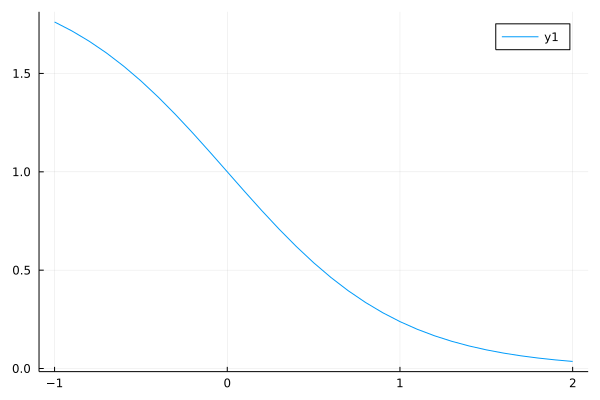

In [190]:
# function active_weights(W,z)
#     return diagm(Int.((W*z) .> 0))*W
# end


# function HingeLoss_0(y; slope=-10, eps = .1)
#     return sum((max.(0,slope .* y .- eps .* slope)).^2)/size(y,2)
# end

# function HingeLoss_1(y; slope = 10, eps = .1)
#     return sum((max.(0, slope .* y .- slope .* (1+eps) )).^2 )/size(y,2)
# end

# function Hinge_0_1(y;slope = 1)
#     max.(-1 .*max.(0, abs.(y) ) .+ 1, 0)
# end

# function BCE_own(ŷ, y; ϵ =1e-5)
#     sum(@.(-y * log(Hinge_0_1_v2(ŷ) +ϵ) - (1 - y) * log(Hinge_0_1(ŷ) + ϵ)))/size(y,2)
# end


# function Hinge_0_1_v2(y;slope = 1)
#     max.(-1 .* max.(0, abs.(y - 1 )) + 1 , 0)
# end

x = -1:.1:2
plot(x, (α .- sigmoid_scaled.(x))/α )


In [3]:
function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function save_model(encoder_μ, encoder_logvar, W1, W2, W3, Q, save_dir::String, epoch::Int)
    print("Saving model...")
    let encoder_μ = cpu(encoder_μ), encoder_logvar = cpu(encoder_logvar), W1 = cpu(W1), W2 = cpu(W2), W3 = cpu(W3), Q = cpu(Q)
        @save joinpath(save_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    end
    println("Done")
end

function create_vae()
    # Define the encoder and decoder networks
    encoder_features = Chain(
        Dense(784,500, relu),
        Dense(500,500, relu)
    )
    encoder_μ = Chain(encoder_features, Dense(500, 20))
    encoder_logvar = Chain(encoder_features, Dense(500, 20))

    W1 = randn(500,20)
    W2 = randn(500,500)
    W3 = randn(500,500)
    Q = randn(784,500)

    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end


# function sigmoid_scaled(x)
#     α = (exp(1) + exp(-1))/(exp(1) - exp(-1))
#     return α * (exp(x) - exp(-x))/(exp(x) + exp(-x)) 
# end

# function BCE_own(ŷ, y; ϵ =1e-5)
#     α = (exp(1) + exp(-1))/(exp(1) - exp(-1))
#     sum(@.(-y * log( α + sigmoid_scaled(ŷ)  +ϵ) - (1 - y) * log(1 - sigmoid(ŷ)/sigmoid(1) + ϵ)))/size(y,2)
# end
# y = randn(5)
# ŷ = randn(5)
# α = (exp(1) + exp(-1))/(exp(1) - exp(-1))


function BCE_own(x̂,x)
    return sum( @.( -(1-x)*log(1 - (sigmoid(abs(x̂)) .- .5) * min((abs(x̂))^1.1, 1) + 1e-5)  - x*( log(1 - (sigmoid(abs(1 - x̂)) .- .5) * min((abs(1-x̂))^1.1, 1)  + 1e-5) ) ) )/784
end


BCE_own (generic function with 1 method)

In [7]:
function vae_loss(encoder_μ, encoder_logvar, W1, W2, W3, Q, x, β, λ, F)
    batch_size = size(x)[end]
    @assert batch_size != 0

    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample

    x̂ = Q*relu(W2*relu(W1*z))

    loss_α(F,A) = maximum(sqrt.(sum((F*A).*(F*A), dims = 2))) + 100*norm(A'*A - I(500),2)^2
    temp = norm(x̂,2)^2
    Loss = maximum((F*x).*(F*x))/temp
    #α = loss_α(F, Q) 
    
    # Negative reconstruction loss Ε_q[logp_x_z]
    # logp_x_z = -sum(binarycrossentropy.(x̂, x)) 

    # logp_x_z = -sum(BCE_own.(x̂,x))


    # loss_mse_2 = sum(@.( - (1-x) * log(1 - exp(-abs(x)) + 1e-5 )))/784 #         (1-exp(-abs(1- x̂))) *

    loss_mse = sum(BCE_own.(x̂,x))

    println(loss_mse)
    println(BCE_own.(x̂,x))
    i = 1 

    # KL(qᵩ(z|x)||p(z)) where p(z)=N(0,1) and qᵩ(z|x) models the encoder i.e. reverse KL
    # The @. macro makes sure that all operates are elementwise
    kl_q_p = 0.5f0 * sum(@. (exp(logvar) + μ^2 - logvar - 1f0)) 
    # Weight decay regularisation term
    reg = λ * sum(x->sum(x.^2), Flux.params(encoder_μ, encoder_logvar, W1, W2, Q))
    # We want to maximise the evidence lower bound (ELBO)
    elbo = - β .* kl_q_p
    # So we minimise the sum of the negative ELBO and a weight penalty
    return -elbo + reg + loss_mse  #+ 10*norm(x̂, Inf) #+ 7000 * α 
end

function train(encoder_μ, encoder_logvar, W1, W2, W3, Q, dataloader, num_epochs, λ, β, optimiser, save_dir)
    # The training loop for the model
    trainable_params = Flux.params(encoder_μ, encoder_logvar, W1, W2, W3, Q)
    progress_tracker = Progress(num_epochs, "Training a epoch done")
    F = dct(diagm(ones(784)),2);

    for epoch_num = 1:num_epochs
        acc_loss = 0.0
        loss = 0
        for (x_batch, y_batch) in dataloader
            # pullback function returns the result (loss) and a pullback operator (back)
            loss, back = pullback(trainable_params) do
                vae_loss(encoder_μ, encoder_logvar, W1, W2, W3, Q, x_batch, β, λ, F)
            end
            # Feed the pullback 1 to obtain the gradients and update then model parameters
            gradients = back(1f0)
            Flux.Optimise.update!(optimiser, trainable_params, gradients)
            if isnan(loss)
                break
            end
            acc_loss += loss
        end
        next!(progress_tracker; showvalues=[(:loss, loss)])
        @assert length(dataloader) > 0
        avg_loss = acc_loss / length(dataloader)
        metrics = DataFrame(epoch=epoch_num, negative_elbo=avg_loss)
        println(metrics)
        CSV.write(joinpath(save_dir, "metrics.csv"), metrics, header=(epoch_num==1), append=true)
        save_model(encoder_μ, encoder_logvar, W1, W2, W3, Q, save_dir, epoch_num)
    end
    println("Training complete!")
end

train (generic function with 1 method)

In [8]:
batch_size = 64
shuffle_data = true
η = 0.001
β = 1f0
λ = 0.01f0
num_epochs = 15

save_dir = "trained_GNN/MNIST_ortho"
# Define the model and create our data loader
dataloader = get_train_loader(batch_size, shuffle_data)
encoder_μ, encoder_logvar, W1, W2, W3, Q  = create_vae()
train(encoder_μ, encoder_logvar, W1, W2, W3, Q, dataloader, num_epochs, λ, β, ADAM(η, (0.9,0.8)), save_dir)

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


44.31710262374112


[0.0008840907917856412 0.0008840907917856022 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840479193134251 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856231 0.0008840907917856412 0.0008840907917856412 0.0008840907917856407 0.0008840907917856412 0.0008840907917856412 0.0008840907917856407 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.00088409

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840732245234832 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840743053315855 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907006545856 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907891672174 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856197 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008732291684381829 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856407 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856407 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856248 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840902267001664 0.0008840907561492835 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840905655463894 0.0008840907917855608; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840881615158145 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907914805218 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917852141 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.000884090791785635 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000738333212441869 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0006723021011369264 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840828461840937 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.00088409

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0005290149427388408 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008693768578989981 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856411 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008353363157644271 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0005880017958231903 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840898275694024 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008573120358409675 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856038 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0003645819336386826 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856411 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

0.0008840907917856414 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.00088409

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008707655586054858 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 4.2780777470000435e-5 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917821458 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856411 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907911476264 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840791672537222 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884090791785242 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907916946773 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008678680434005149 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907911530773 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.00088409

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856208 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907713208071 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917855166 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.00088409

; 0.0008840907917657393 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008839348655697632 0.0008840907914734091 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0003278585108453957 0.0008840907917856412 0.0008840425754681734 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008282996618695489 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907896067085 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840769193286523 0.0008840907917856411 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856414 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856414 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917619543 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008839515823759334 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884090791785494 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856407 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856411 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907786134785 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856361 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917251081 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856407 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0003506539003726832 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884090791785638 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856411 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856361 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840862185168015 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856316 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907736222305 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856414 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856411 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856411 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856411 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907905222831 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917855381 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856411 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008827460549642939 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884090791785473 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917838065 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907916957671 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856411 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856414 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008839765201928523 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856414 0.0008840907917856412 0.000884090791785638 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884090

 0.0008840907917856412 0.0008840907767874995 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

Excessive output truncated after 524290 bytes.

 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917825666 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412; 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856414 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.0008840907917856412 0.000884

In [52]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function save_to_images(x_batch, save_dir::String, prefix::String, num_images::Int64)
    @assert num_images <= size(x_batch)[2]
    for i=1:num_images
        save(joinpath(save_dir, "$prefix-$i.png"), colorview(Gray, reshape(x_batch[:, i], 28,28)' ))
    end
end

function reconstruct_images(encoder_μ, encoder_logvar, W1, W2, W3, Q, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = Q*relu(W2*relu(W1*z))
    return clamp.(x̂, 0 ,1)
end

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end

function visualise()
    # Define some parameters
    batch_size = 64
    shuffle = true
    num_images = 20
    epoch_to_load = 1
    # Load the model and test set loader
    dir = "trained_GNN/MNIST_ortho"
    encoder_μ, encoder_logvar, W1, W2, W3, Q = load_model_identity(dir, epoch_to_load)
    dataloader = get_test_loader(batch_size, shuffle)
    # Reconstruct and save some images
    for (x_batch, y_batch) in dataloader
        save_to_images(x_batch, dir, "test-image", num_images)
        x̂_batch = reconstruct_images(encoder_μ, encoder_logvar, W1, W2, W3, Q, x_batch)
        save_to_images(x̂_batch, dir, "reconstruction", num_images)
        break
    end
end


visualise (generic function with 1 method)

In [53]:
visualise()

Loading model...Done


┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:195


┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\Babhru\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\Babhru\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\Babhru\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\Babhru\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storag

In [54]:
load("trained_GNN/MNIST_ortho/reconstruction-3.png")

CapturedException: Png error: PNG unsigned integer out of range
Stacktrace:
  [1] error(s::String)
    @ Base .\error.jl:33
  [2] png_error_handler(#unused#::Ptr{Nothing}, msg::Cstring)
    @ PNGFiles C:\Users\Babhru\.julia\packages\PNGFiles\Ee6Hz\src\wraphelpers.jl:1
  [3] png_read_info
    @ C:\Users\Babhru\.julia\packages\PNGFiles\Ee6Hz\gen\libpng\libpng_api.jl:390 [inlined]
  [4] _load(png_ptr::Ptr{Nothing}, info_ptr::Ptr{Nothing}; gamma::Nothing, expand_paletted::Bool, background::Bool)
    @ PNGFiles C:\Users\Babhru\.julia\packages\PNGFiles\Ee6Hz\src\io.jl:106
  [5] load(fpath::String; gamma::Nothing, expand_paletted::Bool, background::Bool)
    @ PNGFiles C:\Users\Babhru\.julia\packages\PNGFiles\Ee6Hz\src\io.jl:54
  [6] load(fpath::String)
    @ PNGFiles C:\Users\Babhru\.julia\packages\PNGFiles\Ee6Hz\src\io.jl:48
  [7] invokelatest(::Any, ::Any, ::Vararg{Any}; kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ Base .\essentials.jl:716
  [8] invokelatest(::Any, ::Any, ::Vararg{Any})
    @ Base .\essentials.jl:714
  [9] (::LazyModules.LazyFunction)(::String, ::Vararg{Any}; kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ LazyModules C:\Users\Babhru\.julia\packages\LazyModules\d9Be6\src\LazyModules.jl:29
 [10] (::LazyModules.LazyFunction)(::String, ::Vararg{Any})
    @ LazyModules C:\Users\Babhru\.julia\packages\LazyModules\d9Be6\src\LazyModules.jl:28
 [11] load(f::FileIO.File{FileIO.DataFormat{:PNG}, String}; kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ ImageIO C:\Users\Babhru\.julia\packages\ImageIO\xMHN9\src\ImageIO.jl:61
 [12] load(f::FileIO.File{FileIO.DataFormat{:PNG}, String})
    @ ImageIO C:\Users\Babhru\.julia\packages\ImageIO\xMHN9\src\ImageIO.jl:61
 [13] #invokelatest#2
    @ .\essentials.jl:716 [inlined]
 [14] invokelatest
    @ .\essentials.jl:714 [inlined]
 [15] action(::Symbol, ::Vector{Union{Base.PkgId, Module}}, ::FileIO.Formatted; options::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ FileIO C:\Users\Babhru\.julia\packages\FileIO\Nl9Lh\src\loadsave.jl:219
 [16] action
    @ C:\Users\Babhru\.julia\packages\FileIO\Nl9Lh\src\loadsave.jl:197 [inlined]
 [17] action(::Symbol, ::Vector{Union{Base.PkgId, Module}}, ::Symbol, ::String; options::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ FileIO C:\Users\Babhru\.julia\packages\FileIO\Nl9Lh\src\loadsave.jl:185
 [18] action
    @ C:\Users\Babhru\.julia\packages\FileIO\Nl9Lh\src\loadsave.jl:185 [inlined]
 [19] load(::String; options::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ FileIO C:\Users\Babhru\.julia\packages\FileIO\Nl9Lh\src\loadsave.jl:113
 [20] load(::String)
    @ FileIO C:\Users\Babhru\.julia\packages\FileIO\Nl9Lh\src\loadsave.jl:110
 [21] top-level scope
    @ c:\Users\Babhru\Documents\GitHub\GNN_Isometries\train_vae_incoherent_orthogonal_abs.ipynb:1

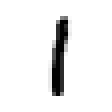

In [21]:
load("trained_GNN/MNIST_ortho/test-image-3.png")

Loading model...Done


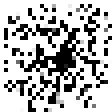

In [27]:
function subspace_incoherence(F, A)
    m, _ = size(A)
    Q = Matrix(qr(A).Q)
    temp = Q'*F'
    return maximum(sqrt.(sum(temp.*temp, dims = 1)))

end


epoch_to_load = 20
# Load the model and test set loader
dir = "trained_GNN/MNIST_ortho_inf"
encoder_μ, encoder_logvar, W1, W2, W3, Q = load_model_identity(dir, epoch_to_load)

colorview(Gray, reshape(sigmoid(Q*relu(W2*relu(W1*randn(20)))), 28,28)')




In [48]:
# pick a image in MNIST to denoise
num = 9
batch_size = 64
shuffle_data = true
dataloader = get_test_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

a= x_batch[:,i];
num = 9
batch_size = 64
shuffle_data = true
dataloader = get_test_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

b= x_batch[:,i];

a = randn(784)
b = randn(784)

BCE_abs(a,a)



┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:195


┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:195


-1.0447461576998724

In [41]:

function BCE_abs(y,ŷ)
    n = length(y)     
    return sum(y .* (1 .-ŷ).^2 .+ (1 .-y) .* ŷ.^2 )/n
end


BCE_abs (generic function with 1 method)

In [223]:
1 .* (1 .-1).^2

0

In [234]:
findmax(a .* (1 .-a).^2 .+ (1 .-a) .* a.^2 )

(0.2499654f0, 682)

In [236]:
a[682]

0.49411762f0

In [238]:
binarycrossentropy(.5,.5)

0.6931471805599448

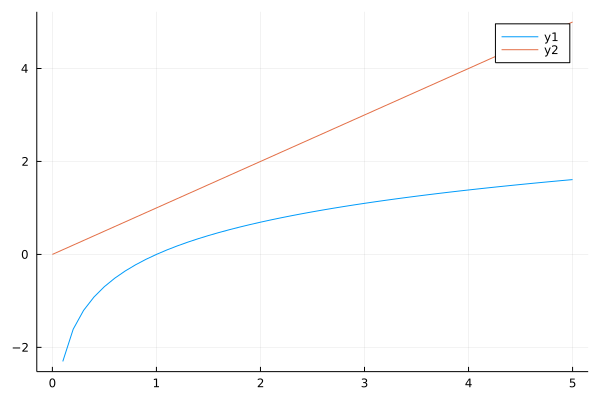

In [60]:
x = 0:.1:5
plot(x, (log.(x)))
plot!(x,x)

In [55]:
using Plots

In [26]:
G= Chain(W1,BatchNorm(500,relu),W2,BatchNorm(500,relu),Q)


Chain(
  [0.9540009579563995 -0.20157499513526944 … -0.10872506366385812 0.2206843543034962; 1.028626957929561 1.2031359009171678 … 0.7166674231298557 -0.8344791232280351; … ; 0.4233654264887103 1.708890845864674 … 0.1887190172377177 -1.261494566716157; 1.126585046254972 0.6106948064927072 … -0.19272993365977495 0.7365404633122145],  # 10_000 parameters
  BatchNorm(500, relu),                 # 1_000 parameters, plus 1_000
  [-0.02100126986028349 -0.0208255389190168 … 0.012129144593788109 -0.01327103391473498; 0.509125383846512 0.613226685766326 … -0.18342071519760184 -0.05944047428268638; … ; 0.42908990550103654 -0.3791300260053892 … 0.1254331664805604 0.7016253464186287; 0.2296483271589124 0.11310975845437268 … -0.9983346394128763 0.44056991083191127],  # 250_000 parameters
  BatchNorm(500, relu),                 # 1_000 parameters, plus 1_000
  [0.0018416437192882824 -0.1659219261502641 … -0.674427553275879 0.5022102390167911; -0.008976157511977964 -0.15412155820903858 … -0.96079177

In [42]:
m = Chain(x -> W1*x)

m(randn(20))


500-element Vector{Float64}:
 -1.0804073139353663
  0.5464267041028211
 -1.5812756760818945
 -2.923672995016764
  3.8370733866588753
 -0.7064200123783214
 -3.7084653790893887
  3.483898538802718
  3.4485148788256477
  3.382998293181162
  ⋮
 -4.399791340214901
  4.440578943115084
  1.315862808583593
 -1.3308986044533593
  2.1770122886863117
  4.1888149512806105
 -3.630979365404509
  3.457519277698261
  5.464177910711132